In [9]:
import numpy as np
from shapely.geometry import Polygon
from cellpose import utils
import numpy as np
import tifffile
from shapely.geometry import Polygon, box


In [2]:
fullres_chanel_0 = r"G:\Alexis_data\Project\SpatialOmics_cellpose\data\output-XETG00245__0034182__1835od__20240613__195055\morphology_focus\morphology_focus_0000.ome.tif"

def get_image_shape(file_path):
    with tifffile.TiffFile(file_path) as tif:
        image = tif.asarray()
        shape = image.shape
    return shape

# Usage
shape = get_image_shape(fullres_chanel_0)
print(f"Image shape: {shape}")

<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


Image shape: (4, 20519, 19977)


In [3]:
ROI_filepath = "G:/Alexis_data/Project/SpatialOmics_cellpose/data/output-XETG00245__0034182__1835od__20240613__195055/1835od_corneasection.csv"

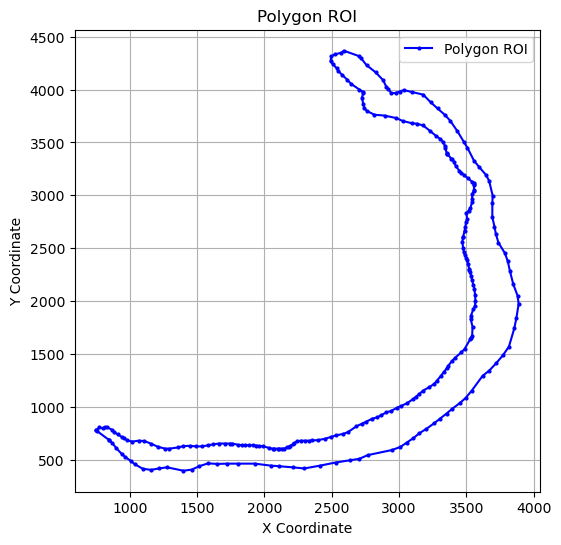

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Read the ROI coordinates from the CSV file
polygon_coords = pd.read_csv(ROI_filepath)

# Extract the X and Y coordinates
x_coords = polygon_coords['X']
y_coords = polygon_coords['Y']


# Create a plot
plt.figure(figsize=(6, 6))
plt.plot(x_coords, y_coords, marker='o', linestyle='-', color='b', label='Polygon ROI', markersize=2)

# Close the polygon by connecting the last point to the first
plt.plot([x_coords.iloc[0], x_coords.iloc[-1]], [y_coords.iloc[0], y_coords.iloc[-1]], 'b-')

# Adding labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title("Polygon ROI")
plt.legend()
plt.grid(True)

In [28]:
def crop_polygon_to_squares(polygon, square_size, overlap_size=40, with_overlap=True):
    """
    Crops a polygon into square regions of a given size, with or without overlap.

    Args:
        polygon (Polygon): The input polygon to crop.
        square_size (float): The base size of each square region (side length).
        overlap_size (float): The amount of overlap in um (default: 40).
        with_overlap (bool): Whether to include overlap between squares (default: True).

    Returns:
        List[Polygon]: List of square polygons that intersect with the input polygon.
    """
    # Get bounding box of the polygon
    minx, miny, maxx, maxy = polygon.bounds
    squares = []

    if with_overlap:
        # Generate grid of overlapping squares
        for x in range(int(minx), int(maxx), square_size):
            for y in range(int(miny), int(maxy), square_size):
                square = box(
                    x,                               # minx (unchanged)
                    y,                               # miny (unchanged)
                    x + square_size + overlap_size,  # maxx (expanded)
                    y + square_size + overlap_size   # maxy (expanded)
                )
                if polygon.intersects(square):
                    squares.append(square)
    else:
        # Generate grid of non-overlapping squares
        for x in range(int(minx), int(maxx), square_size):
            for y in range(int(miny), int(maxy), square_size):
                square = box(
                    x,                    # minx
                    y,                    # miny
                    x + square_size,      # maxx (no overlap)
                    y + square_size       # maxy (no overlap)
                )
                if polygon.intersects(square):
                    squares.append(square)

    return squares



In [10]:
# 1. Rescale the coordinates
# Levels: pixelsize in µm https://kb.10xgenomics.com/hc/en-us/articles/11636252598925
scalefactors = {
    0: 0.2125,
    1: 0.4250,
    2: 0.85,
    3: 1.7,
    4: 3.4,
    5: 6.8,
    6: 13.6,
    7: 27.2,
}

level = 0
pixelsize = scalefactors[level]

# Rescale the coordinates

scaling_factor = pixelsize
x_coords_rescaled = x_coords / scaling_factor
y_coords_rescaled = y_coords / scaling_factor

# Combine X and Y into coordinate pairs
rescaled_polygon_roi = list(zip(x_coords_rescaled, y_coords_rescaled))

# Create a Polygon object
rescaled_polygon_roi = Polygon(rescaled_polygon_roi)

square: POLYGON ((5399 1859, 5399 3741, 3517 3741, 3517 1859, 5399 1859))
 x: array('d', [5399.0, 5399.0, 3517.0, 3517.0, 5399.0]) 
 y: array('d', [1859.0, 3741.0, 3741.0, 1859.0, 1859.0])
square: POLYGON ((5399 3741, 5399 5623, 3517 5623, 3517 3741, 5399 3741))
 x: array('d', [5399.0, 5399.0, 3517.0, 3517.0, 5399.0]) 
 y: array('d', [3741.0, 5623.0, 5623.0, 3741.0, 3741.0])
square: POLYGON ((7281 1859, 7281 3741, 5399 3741, 5399 1859, 7281 1859))
 x: array('d', [7281.0, 7281.0, 5399.0, 5399.0, 7281.0]) 
 y: array('d', [1859.0, 3741.0, 3741.0, 1859.0, 1859.0])
square: POLYGON ((9163 1859, 9163 3741, 7281 3741, 7281 1859, 9163 1859))
 x: array('d', [9163.0, 9163.0, 7281.0, 7281.0, 9163.0]) 
 y: array('d', [1859.0, 3741.0, 3741.0, 1859.0, 1859.0])
square: POLYGON ((11045 1859, 11045 3741, 9163 3741, 9163 1859, 11045 1859))
 x: array('d', [11045.0, 11045.0, 9163.0, 9163.0, 11045.0]) 
 y: array('d', [1859.0, 3741.0, 3741.0, 1859.0, 1859.0])
square: POLYGON ((12927 1859, 12927 3741, 11045 3

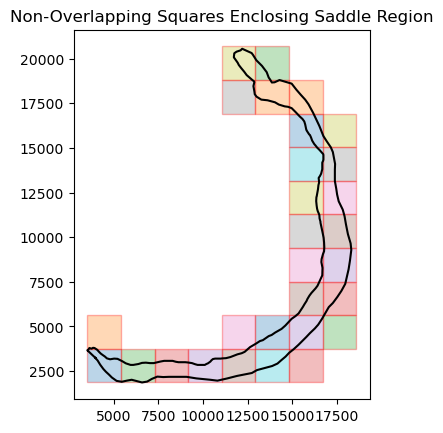

In [61]:


# Define square size
square_size = int(400/0.2125) # Adjust as necessary 


# For overlapping squares
# TODO: overlap_size/0.2125
overlapping_squares = crop_polygon_to_squares(rescaled_polygon_roi, square_size, overlap_size=40, with_overlap=True)

# For non-overlapping squares
non_overlapping_squares = crop_polygon_to_squares(rescaled_polygon_roi, square_size, with_overlap=False)

# Visualization
fig, ax = plt.subplots()
# Plot the original polygon
x, y = rescaled_polygon_roi.exterior.xy
ax.plot(x, y, 'k-', label="Saddle-shaped Polygon")  # Black for polygon

# Plot the square regions
for square in non_overlapping_squares:
    print("square:", square)
    x, y = square.exterior.xy
    print(" x:", x,"\n", "y:", y)
    ax.fill(x, y, edgecolor='red', alpha=0.3, label="Red Square")

# Add labels and legend
ax.set_title(f"Non-Overlapping Squares Enclosing Saddle Region")
ax.set_aspect('equal', 'box')
# ax.legend(loc="upper left")
plt.show()

In [ ]:


# Original image size
original_image_shape = (20519, 19977)  # Replace with the shape of your original image (H, W)

# Initialize a blank canvas for the combined masks
combined_mask = np.zeros(original_image_shape, dtype=np.uint16)

# Function to map segmentation outlines back to original coordinates
def map_to_original_coordinates(outlines, offset):

    min_x, min_y = offset
    
    return [outline + np.array([min_x, min_y]) for outline in outlines]

outlines_list = []

# Example processing loop for 3 cropped regions
for i, square in enumerate(overlapping_squares):
    
    # Stop the loop when i = 30
    if i + 1 == 6:
        i1 = i + 1
        print("Reached the stopping condition: number = {i1}. Exiting the loop.")
        break

    print(f"Processing square {i + 1}: {square}")
    
    # Get bounding box of the current polygon (cropped region)
    min_x, min_y, max_x, max_y = map(int, square.bounds)

    # Load the segmentation result for the cropped region
    segmentation_file = f"G:/Alexis_data/Project/SpatialOmics_cellpose/results/segmenatation/1835od/cp_masks_cropped_square_com_{i + 1}_seg.npy"
    segmentation_data = np.load(segmentation_file, allow_pickle=True).item()
    
    # Extract outlines from    the segmentation
    outlines = utils.outlines_list(segmentation_data['masks'])

    # Map outlines back to original coordinates
    mapped_outlines = map_to_original_coordinates(outlines, (min_x, min_y))
    outlines_list.extend(mapped_outlines)

Processing square 1: POLYGON ((5439 1859, 5439 3781, 3517 3781, 3517 1859, 5439 1859))
Processing square 2: POLYGON ((5439 3741, 5439 5663, 3517 5663, 3517 3741, 5439 3741))
Processing square 3: POLYGON ((7321 1859, 7321 3781, 5399 3781, 5399 1859, 7321 1859))
Processing square 4: POLYGON ((9203 1859, 9203 3781, 7281 3781, 7281 1859, 9203 1859))
Processing square 5: POLYGON ((11085 1859, 11085 3781, 9163 3781, 9163 1859, 11085 1859))
Reached the stopping condition: number = {i1}. Exiting the loop.


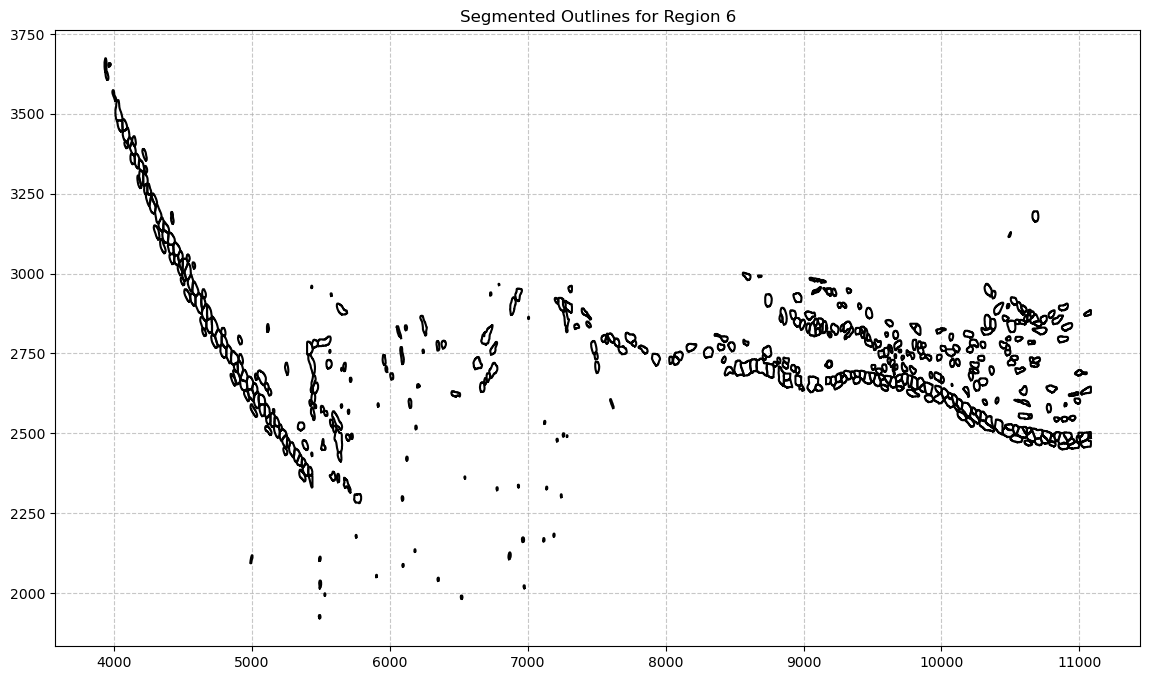

In [23]:
# Plot the outlines
fig, ax = plt.subplots(figsize=(14, 8))

for o in outlines_list:
    ax.plot(o[:, 0], o[:, 1], color='black')

ax.set_title(f"Segmented Outlines for Region {i + 1}")
ax.grid(True, linestyle='--', alpha=0.7)  # Add grid with dashed lines
ax.axis('on')
plt.show()


In [27]:
import pandas as pd
import glob
import os

def load_centroid_files(input_dir):
    centroids_by_region = {}
    
    # Get all centroid CSV files
    files = glob.glob(os.path.join(input_dir, '*centroids.csv'))
    print(f"Found {len(files)} centroid files")
    
    for file in files:
        # Extract region number from filename
        # For pattern: cp_masks_cropped_square_com_1_centroids.csv
        filename = os.path.basename(file)  # Get just the filename
        region = int(filename.split('_com_')[1].split('_')[0])  # Extract number after '_com_'
        
        df = pd.read_csv(file)
        centroids_by_region[region] = df
        print(f"Region {region}: loaded {len(df)} points")
        
    return centroids_by_region

# Usage
centroids_dict = load_centroid_files('G:/Alexis_data/Project/SpatialOmics_cellpose/results/segmenatation/1835od')

Found 29 centroid files
Region 10: loaded 117 points
Region 11: loaded 135 points
Region 12: loaded 90 points
Region 13: loaded 12 points
Region 14: loaded 0 points
Region 15: loaded 190 points
Region 16: loaded 113 points
Region 17: loaded 1 points
Region 18: loaded 0 points
Region 19: loaded 13 points
Region 1: loaded 112 points
Region 20: loaded 14 points
Region 21: loaded 73 points
Region 22: loaded 15 points
Region 23: loaded 0 points
Region 24: loaded 154 points
Region 25: loaded 197 points
Region 26: loaded 193 points
Region 27: loaded 152 points
Region 28: loaded 109 points
Region 29: loaded 4 points
Region 2: loaded 0 points
Region 3: loaded 93 points
Region 4: loaded 71 points
Region 5: loaded 211 points
Region 6: loaded 161 points
Region 7: loaded 0 points
Region 8: loaded 1 points
Region 9: loaded 62 points


In [91]:
import pandas as pd
import numpy as np
import glob
import os
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

def load_and_offset_centroids(input_dir, overlapping_squares):
    """
    Load centroid CSV files and add offsets based on polygon bounds.
    """
    centroids_by_region = {}
    
    # Get all centroid CSV files
    files = glob.glob(os.path.join(input_dir, '*centroids.csv'))
    print(f"Found {len(files)} centroid files")
    
    # Debug: print all found files
    print("\nFound files:")
    for f in files:
        print(f"  {os.path.basename(f)}")
    
    for file in files:
        try:
            # Extract region number from filename
            filename = os.path.basename(file)
            print(f"\nProcessing file: {filename}")
            
            # More robust filename parsing
            parts = filename.split('_')
            # Look for the part after 'com' and before 'centroids'
            com_index = parts.index('com') if 'com' in parts else -1
            if com_index != -1 and com_index + 1 < len(parts):
                region = int(parts[com_index + 1])
                print(f"Extracted region number: {region}")
            else:
                print(f"Skipping file {filename} - could not extract region number")
                continue
            
            # Get corresponding polygon bounds for this region
            if region <= len(overlapping_squares):
                polygon = overlapping_squares[region - 1]  # region is 1-based
                min_x, min_y, max_x, max_y = map(int, polygon.bounds)
                
                # Load and offset the centroids
                df = pd.read_csv(file)
                print(f"Loaded {len(df)} points from CSV")
                
                # Add offsets to the centroid coordinates
                df['centroid_x'] = df['centroid_x'] + min_x
                df['centroid_y'] = df['centroid_y'] + min_y
                
                centroids_by_region[region] = df
                print(f"Region {region}: processed {len(df)} points, offset by ({min_x}, {min_y})")
            else:
                print(f"Warning: Region {region} has no corresponding polygon (max region: {len(overlapping_squares)})")
                
        except Exception as e:
            print(f"Error processing file {filename}: {str(e)}")
            print(f"File parts: {parts}")
            continue
    
    if not centroids_by_region:
        raise ValueError("No valid centroid files were processed!")
        
    return centroids_by_region



In [ ]:
def map_centroids_to_nonoverlapping(centroids_dict, non_overlapping_squares):
    """
    Maps offset centroids to their corresponding non-overlapping squares.
    """
    mapped_centroids = []
    points_outside = []
    
    # Process each region's centroids
    for region, df in centroids_dict.items():
        print(f"Processing centroids from region {region}")
        
        for _, row in df.iterrows():
            point = Point(row['centroid_x'], row['centroid_y'])
            point_mapped = False
            
            # Find which non-overlapping square contains this point
            for idx, square in enumerate(non_overlapping_squares):
                if square.contains(point):
                    mapped_centroids.append({
                        'original_region': region,
                        'mapped_region': idx + 1,
                        'centroid_x': row['centroid_x'],
                        'centroid_y': row['centroid_y'],
                        'cell_type': row.get('cell_type', None),
                        'area': row.get('area', None)
                    })
                    point_mapped = True
                    break
            
            if not point_mapped:
                points_outside.append({
                    'original_region': region,
                    'centroid_x': row['centroid_x'],
                    'centroid_y': row['centroid_y']
                })
    
    # Convert to DataFrame
    result_df = pd.DataFrame(mapped_centroids)
    outside_df = pd.DataFrame(points_outside)
    
    # Print statistics
    print(f"\nTotal centroids processed: {len(result_df)}")
    print(f"Points not mapped to any square: {len(outside_df)}")
    print("\nCentroids per mapped region:")
    if not result_df.empty:
        print(result_df['mapped_region'].value_counts().sort_index())
    
    return result_df, outside_df

def visualize_mapped_centroids(result_df, outside_df, non_overlapping_squares, figsize=(15, 15)):
    """
    Visualizes the mapped centroids and squares.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot non-overlapping squares
    for idx, square in enumerate(non_overlapping_squares):
        x, y = square.exterior.xy
        ax.plot(x, y, 'k-', linewidth=2, alpha=0.7)
        # Add region number label
        centroid = square.centroid
        ax.text(centroid.x, centroid.y, str(idx + 1), 
                horizontalalignment='center', 
                verticalalignment='center',
                fontsize=12,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    
    # Plot mapped centroids
    if not result_df.empty:
        scatter = ax.scatter(result_df['centroid_x'], result_df['centroid_y'], 
                           c=result_df['mapped_region'], 
                           cmap='tab20', 
                           alpha=0.6, 
                           s=30,
                           label='Mapped points')
        plt.colorbar(scatter, label='Mapped Region')
    
    # Plot points outside any square in red
    if not outside_df.empty:
        ax.scatter(outside_df['centroid_x'], outside_df['centroid_y'], 
                  color='red', 
                  alpha=0.6, 
                  s=30,
                  label='Unmapped points')
    
    ax.set_title('Mapped Centroids in Non-overlapping Regions')
    ax.legend()
    ax.set_aspect('equal')
    plt.show()

Found 31 centroid files

Found files:
  cp_masks_cropped_square_com_10_centroids.csv
  cp_masks_cropped_square_com_11_centroids.csv
  cp_masks_cropped_square_com_12_centroids.csv
  cp_masks_cropped_square_com_13_centroids.csv
  cp_masks_cropped_square_com_14_centroids.csv
  cp_masks_cropped_square_com_15_centroids.csv
  cp_masks_cropped_square_com_16_centroids.csv
  cp_masks_cropped_square_com_17_centroids.csv
  cp_masks_cropped_square_com_18_centroids.csv
  cp_masks_cropped_square_com_19_centroids.csv
  cp_masks_cropped_square_com_1_centroids.csv
  cp_masks_cropped_square_com_20_centroids.csv
  cp_masks_cropped_square_com_21_centroids.csv
  cp_masks_cropped_square_com_22_centroids.csv
  cp_masks_cropped_square_com_23_centroids.csv
  cp_masks_cropped_square_com_24_centroids.csv
  cp_masks_cropped_square_com_25_centroids.csv
  cp_masks_cropped_square_com_26_centroids.csv
  cp_masks_cropped_square_com_27_centroids.csv
  cp_masks_cropped_square_com_28_centroids.csv
  cp_masks_cropped_squa

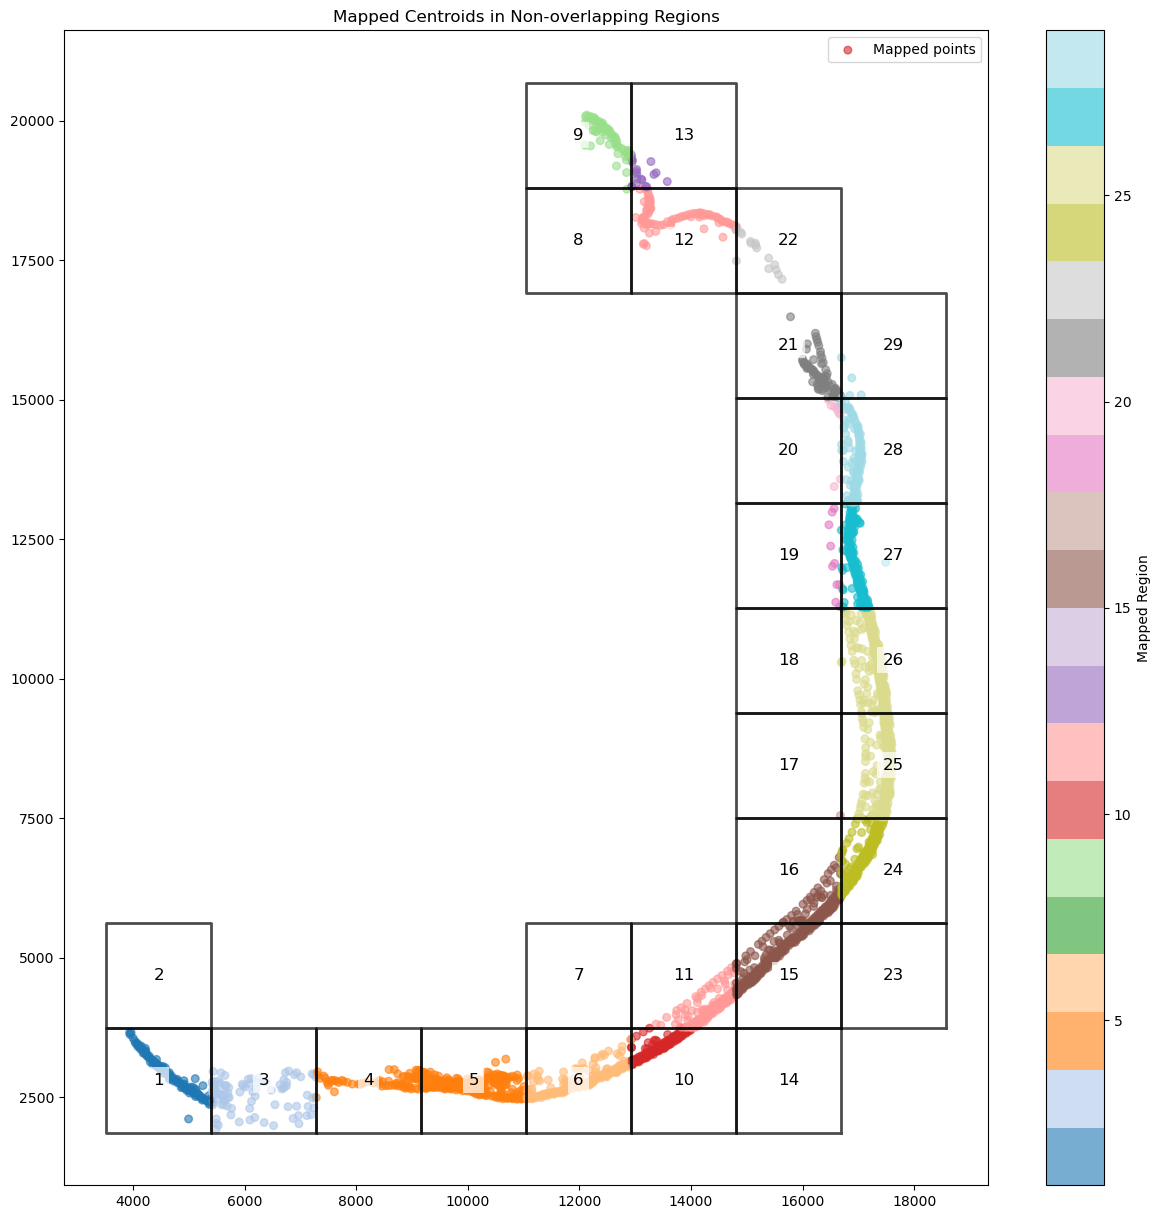


Results saved to: G:/Alexis_data/Project/SpatialOmics_cellpose/results/segmenatation/1835od


In [92]:
# Example usage:
if __name__ == "__main__":
    input_dir = 'G:/Alexis_data/Project/SpatialOmics_cellpose/results/segmenatation/1835od'
    
    # 1. Load and offset the centroid data using overlapping squares for offsets
    centroids_dict = load_and_offset_centroids(input_dir, overlapping_squares)
    
    # 2. Map offset centroids to non-overlapping regions
    mapped_df, outside_df = map_centroids_to_nonoverlapping(centroids_dict, non_overlapping_squares)
    
    # 3. Visualize the results
    visualize_mapped_centroids(mapped_df, outside_df, non_overlapping_squares)
    
    # 4. Save the results
    output_dir = input_dir
    mapped_df.to_csv(os.path.join(output_dir, 'mapped_centroids.csv'), index=False)
    if not outside_df.empty:
        outside_df.to_csv(os.path.join(output_dir, 'unmapped_centroids.csv'), index=False)
    print(f"\nResults saved to: {output_dir}")

In [ ]:
non_overlapping_squares

In [55]:
from shapely.geometry import Point

In [56]:
def get_non_overlapping_cells(region_number, centroids_df, all_polygons):
    """
    Returns cell IDs whose centroids fall only in their own region
    and not in any other regions
    
    Parameters:
        region_number: Current region number (1-based indexing)
        centroids_df: DataFrame with centroid_x and centroid_y columns
        all_polygons: List of polygon objects for all regions
        
    Returns:
        list: Valid cell IDs whose centroids are only in their own region
    """
    current_polygon = all_polygons[region_number - 1]  # Assuming 1-based indexing
    valid_cell_ids = []
    
   # Convert centroids to points - note the order: x first, then y for Point creation
    for idx, row in centroids_df.iterrows():
        # Create point using x,y order (note we swap the order from the DataFrame)
        point = Point(row['centroid_x'], row['centroid_y'])
        
        # Check if point is in current polygon
        in_current = current_polygon.contains(point)
        
        # Check if point is in any other polygon
        in_others = False
        for i, other_poly in enumerate(all_polygons):
            if i != (region_number - 1):  # Skip current polygon
                if other_poly.contains(point):
                    in_others = True
                    break
        
        # If point is only in current polygon, keep the cell ID
        if in_current and not in_others:
            valid_cell_ids.append(idx + 1)  # Adding 1 because cell IDs start at 1
            
    print(f"Region {region_number}: Found {len(valid_cell_ids)} non-overlapping cells")
    return valid_cell_ids



In [57]:
# Example usage
filtered_outlines_list = []

for i, square in enumerate(overlapping_squares):
    if i + 1 == 6:
        break
        
    region_num = i + 1
    # Get centroids for this region
    centroids = centroids_dict[region_num]
    
    # Get valid cell IDs for this region
    valid_cells = get_non_overlapping_cells(region_num, centroids, overlapping_squares)
    
    print(f"Region {region_num}: Found {len(valid_cells)} non-overlapping cells")
    
    # Load segmentation data and filter outlines
    segmentation_file = f"G:/Alexis_data/Project/SpatialOmics_cellpose/results/segmenatation/1835od/cp_masks_cropped_square_com_{region_num}_seg.npy"
    segmentation_data = np.load(segmentation_file, allow_pickle=True).item()
    outlines = utils.outlines_list(segmentation_data['masks'])
    
    # Filter and map outlines
    min_x, min_y, max_x, max_y = map(int, square.bounds)
    filtered_outlines = [outline for i, outline in enumerate(outlines) if (i + 1) in valid_cells]
    mapped_outlines = map_to_original_coordinates(filtered_outlines, (min_x, min_y))
    filtered_outlines_list.extend(mapped_outlines)

Region 1: Found 0 non-overlapping cells
Region 1: Found 0 non-overlapping cells
Region 2: Found 0 non-overlapping cells
Region 2: Found 0 non-overlapping cells
Region 3: Found 0 non-overlapping cells
Region 3: Found 0 non-overlapping cells
Region 4: Found 0 non-overlapping cells
Region 4: Found 0 non-overlapping cells
Region 5: Found 0 non-overlapping cells
Region 5: Found 0 non-overlapping cells


In [41]:
def filter_outlines(outlines, valid_cell_ids, masks):
    """
    Filter outlines to keep only those corresponding to valid cell IDs
    """
    filtered_outlines = []
    for i, outline in enumerate(outlines):
        # Get cell ID for this outline (i+1 because cell IDs typically start at 1)
        cell_id = i + 1
        if cell_id in valid_cell_ids:
            filtered_outlines.append(outline)
    
    return filtered_outlines

In [58]:
filtered_outlines_list = []

for i, square in enumerate(overlapping_squares):
    if i + 1 == 6:
        break
        
    # Get centroids for this region
    centroids = centroids_dict[i + 1]
    
    # Get valid cell IDs for this region
    valid_cells = get_non_overlapping_cells(i + 1, centroids, overlapping_squares)
    
    # Load and filter outlines
    segmentation_file = f"G:/Alexis_data/Project/SpatialOmics_cellpose/results/segmenatation/1835od/cp_masks_cropped_square_com_{i + 1}_seg.npy"
    segmentation_data = np.load(segmentation_file, allow_pickle=True).item()
    outlines = utils.outlines_list(segmentation_data['masks'])
    
    # Filter outlines to keep only non-overlapping cells
    filtered_outlines = filter_outlines(outlines, valid_cells, segmentation_data['masks'])
    
    # Map filtered outlines to original coordinates
    mapped_outlines = map_to_original_coordinates(filtered_outlines, (min_x, min_y))
    filtered_outlines_list.extend(mapped_outlines)

Region 1: Found 0 non-overlapping cells
Region 2: Found 0 non-overlapping cells
Region 3: Found 0 non-overlapping cells
Region 4: Found 0 non-overlapping cells
Region 5: Found 0 non-overlapping cells


In [38]:
segmentation_data1

{'outlines': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 'masks': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 'chan_choose': [0, 0],
 'ismanual': array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,

In [39]:
print("Data type:", segmentation_data1['masks'].dtype)
print("Unique cell IDs:", np.unique(segmentation_data1['masks']))

Data type: uint16
Unique cell IDs: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152]
